# Reverse MNIST

## Preliminaries

In [402]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

## Load MNIST DATA

In [403]:
howmany = -1 #50
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][:howmany]).float().to(device), torch.tensor(train[1][:howmany]).float().to(device)]

## Create Network

In [465]:
# Shallow Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Class vector
net.AddLayer(Layer.TopPELayer(n=784))  # 1 Input
net.Connect(0,1)
# Input layer is one-hot
net.layers[0].SetActivationFunction('softmax')
# Top vector reconstructed image, [0, 1]
net.layers[-1].SetActivationFunction('logistic')

net.SetTau(0.04)

In [519]:
# Deep Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Class vector
net.AddLayer(Layer.TopPELayer(n=50))  # 1 Hidden
net.AddLayer(Layer.InputPELayer(n=200))  # 2 Hidden
net.AddLayer(Layer.TopPELayer(n=784))  # 3 Image
net.Connect(0,1)
net.Connect(1,2)
net.Connect(2,3)
# Input layer is one-hot
net.layers[0].SetActivationFunction('softmax')
# Top vector reconstructed image, [0, 1]
net.layers[-1].SetActivationFunction('logistic')

net.SetTau(0.08)

In [287]:
net.layers[0].Probe(True)
net.layers[1].Probe(True)

In [509]:
len(net.layers)

4

## Train the Network

In [ ]:
# Train in reverse direction: one-hot -> reconstructed image
epochs = 20
T = 3.
dt = 0.01
start_time = time.time()
batch_size = 100
net.learning_tau = torch.tensor(batch_size).float().to(device) * 15.
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
for k in range(epochs):
    batches = NN.MakeBatches(train[1], train[0], batch_size=batch_size)
    for x in batches:
        #net.Reset()
        net.Infer(T, x[0], x[1], dt=dt)
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

## Probe the Model

In [313]:
z = net.Predict(10., train[1][0], dt=0.01)

In [314]:
plt.plot(net.t_history, np.array(net.layers[1].v_history)[:,200:300]);

IndexError: too many indices for array

## Save the Model

In [457]:
net.Save('MNIST reversed deep.npy')

## Load the Model

In [458]:
net = NN.NeuralNetwork()
net.Load('MNIST reversed.npy')

## Test the Network

In [521]:
net.layers[1].b

tensor([  572.1608,   185.3762,   152.1585,  1432.9124,   159.2349,
          255.0507,   151.2960,   198.7980,   224.0624,   351.1333,
          236.3062,   162.8073,   141.4832,   193.5425,   229.7755,
          293.4392,   215.5477,   188.2749,   145.9199,   158.1493,
          157.3699,   159.6587,   168.0700,   189.9165,   155.9552,
          235.5235,   238.6423,   147.2890,   189.0896,   119.2905,
          226.9520,   147.9452,   171.3660,   243.1548,   147.0254,
          157.3929,   145.4809,   165.8440,   200.9229,   213.5513,
          199.0719,   192.6044,   191.7887,   171.5215,   185.3938,
          419.7314,   197.3938,   164.0730,   151.7574,   885.3657], device='cuda:0')

tensor([ 0.1121,  0.0769,  0.1006,  0.0981,  0.1047,  0.1011,  0.1077,
         0.1110,  0.0798,  0.1054], device='cuda:0')


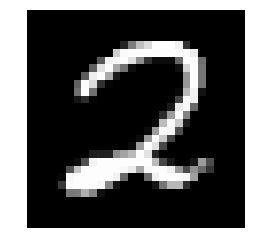

In [522]:
p = 35 #147 or 35   for 2s
#p = 133 #133 or 141   for 7s
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.Reset()
net.SetTau(0.04)
z = net.Generate(1., test[0][p])
y = z #net.layers[1].sigma(z)
print(z)

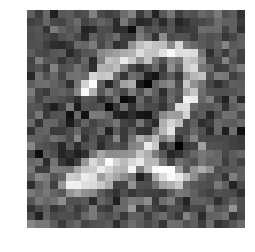

In [523]:
#net.Reset()
z = net.Predict(1., test[1][p])
plt.imshow(np.reshape(z,[28, 28]), cmap='gray'); plt.axis('off');

In [524]:
net.Reset()
net.SetTau(0.04)  # it seems like choosing a value half of that during training works best
yy = net.Generate(4., test[0])
y_true = test[1]
y = yy #np.array([np.array(Layer.softmax(k)) for k in yy])

In [515]:
sum(y[0])

tensor(0.8999, device='cuda:0')

In [525]:
z = np.array(deepcopy(y))
for idx, blah in enumerate(y):
    z[idx,:] = NN.OneHot(blah)

In [526]:
err = np.sum(np.abs(z-test[1]))/2.
print(err)
print('Accuracy = '+str((len(z)-err)/len(z)*100.)+'%')

9020.0
Accuracy = 9.8%
